# Step Detection Log Analysis

In [3]:
# Load the CSV file
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('imu_log.csv')
# Convert timestamps to seconds for plotting
df['time_s'] = (df['timestamp_us'] - df['timestamp_us'].iloc[0]) / 1e6

df.head()

,timestamp_us,ax,ay,az,filtered_mag,time_s
0,5652782.0,0.283,0.027,1.035,0.295,0.000000
1,5658559.0,0.256,-0.021,1.032,0.399,0.005777
2,5668315.0,0.263,0.157,0.967,0.474,0.015533
3,5678264.0,0.249,0.103,0.983,0.532,0.025482
4,5688284.0,0.315,-0.063,1.018,0.584,0.035502


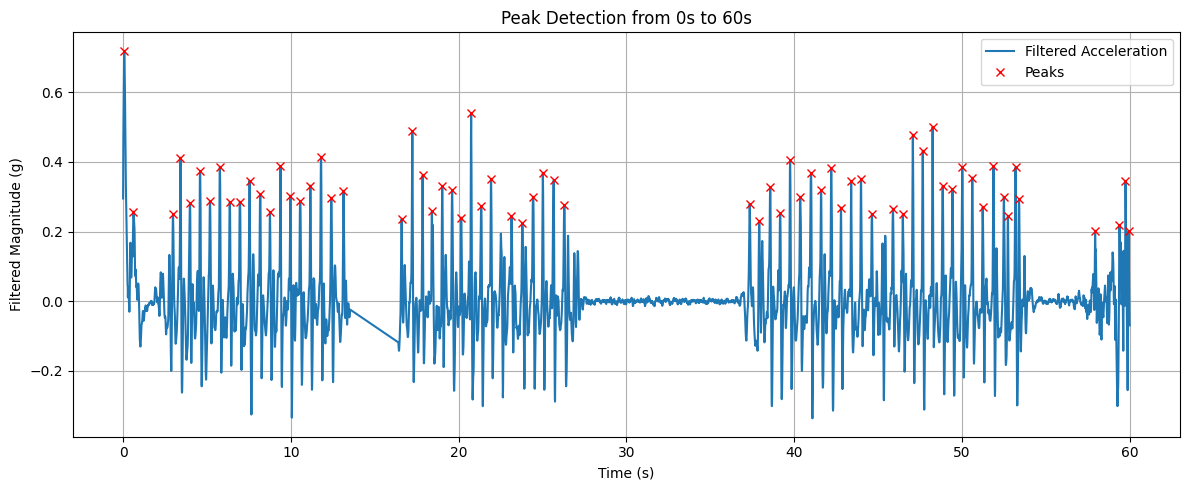

Detected steps: 68


In [6]:
from scipy.signal import find_peaks
start_time = 0    
end_time = 60   

# Filter the DataFrame for the specified time range
df_window = df[(df['time_s'] >= start_time) & (df['time_s'] <= end_time)]

# Try basic detection
peaks, _ = find_peaks(df_window['filtered_mag'], height=0.2, distance=15)  # adjust height & distance as needed

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_window['time_s'], df_window['filtered_mag'], label='Filtered Acceleration')
plt.plot(df_window['time_s'].iloc[peaks], df_window['filtered_mag'].iloc[peaks], "rx", label='Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Filtered Magnitude (g)')
plt.title(f'Peak Detection from {start_time}s to {end_time}s')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Detected steps:", len(peaks))
